<a href="https://colab.research.google.com/github/GIGLT/colab_testing/blob/main/Medical_Services_Request_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [ ]:
# Load the CSV file
df = pd.read_csv('test.csv')
df.head(5)

,Unnamed: 0,Request Type,Issue,Issue Type,SLA Name,Start Count Status name,End Count status name,Pause count Status Name,SLA Time,Calender
0,1,Adding Transactions,Adding Transactions,Task,Data Validation,Issue Created,Canceled,cancel request,6 WH,Normal Calender
1,2,Debit Notes,Debit Notes,Task,Data Validation,Issue Created,Canceled,cancel request,6 WH,Normal Calender
2,3,Ex-Gratia Requests,Ex-Gratia,Task,Data Validation,Issue Created,Canceled,cancel request,6 WH,Normal Calender
3,4,Doctor On-site Request,DOS Request,Task,Data Validation,Issue Created,Canceled,cancel request,24 WH,Normal Calender
4,5,Adding Transactions,Adding Transactions,Task,Data Validation,Issue Created,Medical Claim Approval,cancel request,6 WH,Normal Calender


In [ ]:
# -----------------------------------------------------------------------------
# Data Cleaning
# -----------------------------------------------------------------------------

# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Fill missing values with a sensible default like "Unknown"
df = df.fillna('Unknown')

# Standardize the 'SLA Time' column by removing ' WH' and converting to numeric
df['SLA Time'] = df['SLA Time'].str.replace(' WH', '', regex=False)
df['SLA Time'] = pd.to_numeric(df['SLA Time'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['SLA Time'] = df['SLA Time'].fillna(df['SLA Time'].mean()) #Impute nan values with mean

# Remove leading/trailing spaces from object columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

SLA Time Summary by Request and Issue Type:
                                          mean  median        std  count
Request Type            Issue Type                                     
Adding Transactions     Task         6.000000     6.0   0.000000     12
Case Management         Task         6.984749     4.0   4.776038     12
Complaints              Task        47.428571    80.0  40.623709      7
Debit Notes             Task         6.736842     6.0   0.991189     19
Doctor On-site Request  Task        24.888889    24.0   9.851180     18
Ex-Gratia Requests      Task         4.400000     6.0   2.010499     20
Inquiries               Task         5.333333     4.0   4.114309     24
Meeting Request         Task        16.000000    16.0   0.000000      2
Policy Analysis         Task        16.000000    16.0   0.000000      2
Reimbursement Reprocess Task         4.000000     4.0   0.000000     16
Relaxations             Task         4.000000     4.0   0.000000     16
SMO                

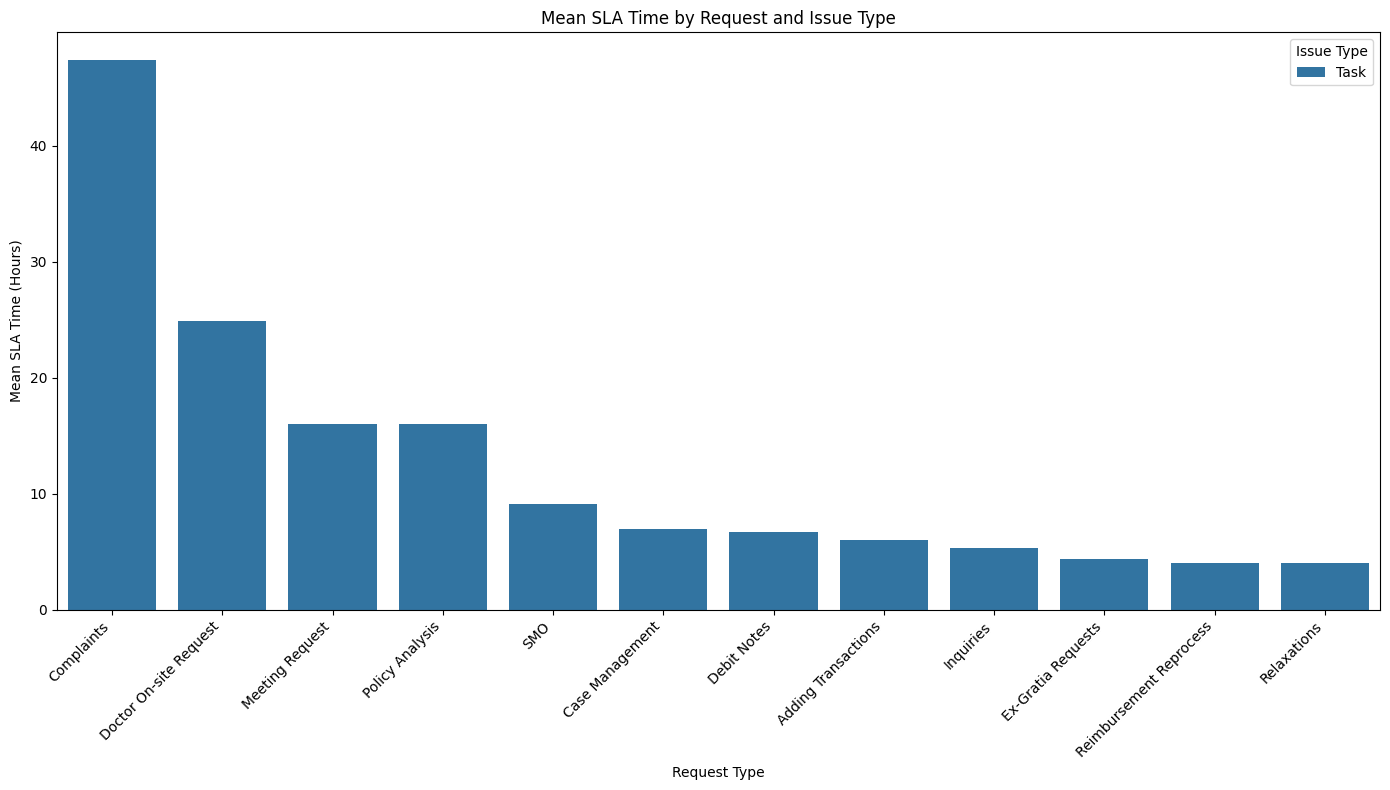

In [ ]:
# -----------------------------------------------------------------------------
# Core Descriptive Analysis & Refinement
# -----------------------------------------------------------------------------

# SLA Time by Request/Issue Type (Detailed)
sla_summary = df.groupby(['Request Type', 'Issue Type'])['SLA Time'].agg(['mean', 'median', 'std', 'count'])
print("SLA Time Summary by Request and Issue Type:\n", sla_summary)

# Visualization: Grouped Bar Chart of Mean SLA Time
sla_summary = sla_summary.sort_values('mean', ascending=False)
sla_summary = sla_summary.reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(data=sla_summary, x='Request Type', y='mean', hue='Issue Type')
plt.title('Mean SLA Time by Request and Issue Type')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean SLA Time (Hours)')
plt.tight_layout()
plt.show()

# SLA Achievement Rate (Example: Define "on-time" as within SLA Time)
#df['On Time'] = df['SLA Time'] >= 0  # Assuming SLA Time should be positive, adjusting ontime variable
#achievement_rate = df.groupby('Request Type')['On Time'].value_counts(normalize=True).unstack() * 100
#print("\nSLA Achievement Rate by Request Type:\n", achievement_rate)

# Visualization: Bar Chart of SLA Achievement Rate
#achievement_rate.plot(kind='bar', stacked=True, figsize=(10, 6))
#plt.title('SLA Achievement Rate by Request Type')
#plt.xlabel('Request Type')
#plt.ylabel('Percentage')
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
#plt.show()


Status Transition Matrix:
 End Count status name         Canceled  Claim Approved  \
Start Count Status name                                  
Complain Validation                  0               0   
Data Request from CS                 1               0   
Entered Status: TPA Feedback         1               0   
Feedback provided                    1               0   
Issue Created                       34               0   
Medical Claim Approval               1               1   
Request Data from CS                 1               0   
Request TPA Feedback                 2               0   
Request Validation                   4               0   
Review cost of Visit                 1               0   
Send to Concerned Department         1               0   
TPA Feedback                         2               0   
TPA Feedback Request                 1               0   

End Count status name         Claim Partial-Approved  Claim Rejected  \
Start Count Status name      

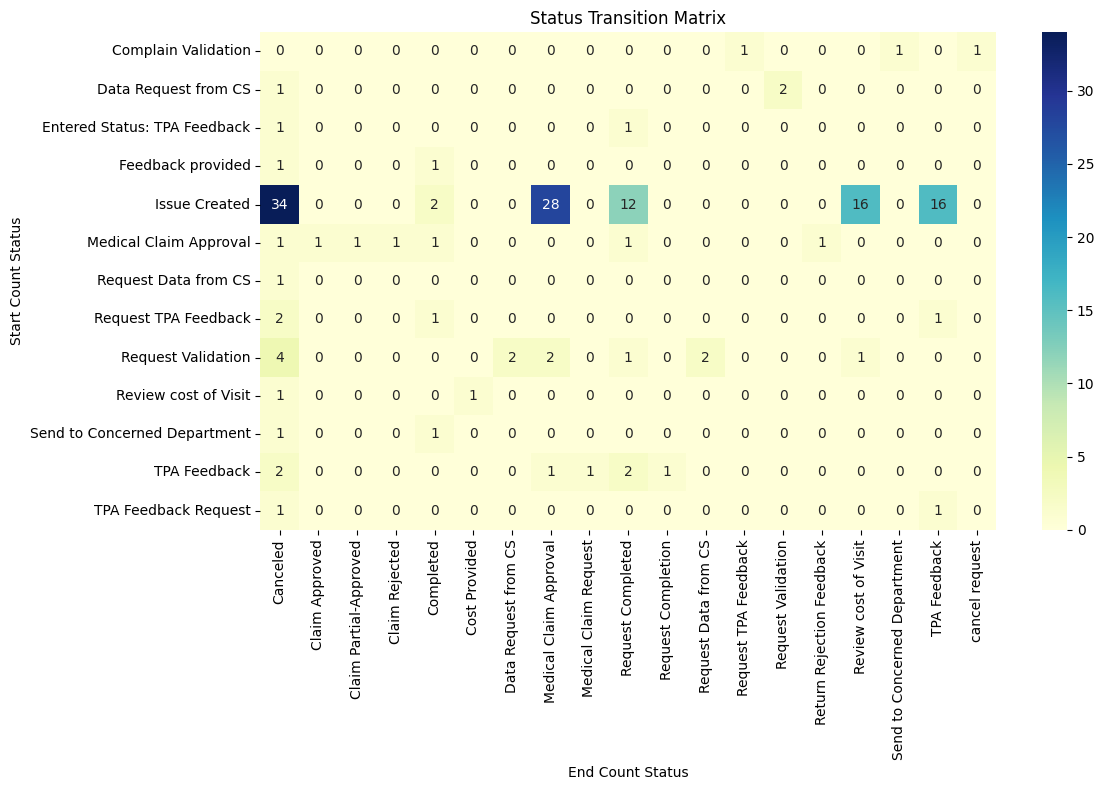

In [ ]:
# -----------------------------------------------------------------------------
# Status Flow Analysis
# -----------------------------------------------------------------------------

# Status Transitions Matrix
transition_matrix = pd.crosstab(df['Start Count Status name'], df['End Count status name'])
print("\nStatus Transition Matrix:\n", transition_matrix)

# Visualization: Heatmap of Status Transition Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(transition_matrix, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Status Transition Matrix')
plt.xlabel('End Count Status')
plt.ylabel('Start Count Status')
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# Relationship between Start and End Status
# -----------------------------------------------------------------------------
# Contingency Table
contingency_table = pd.crosstab(df['Start Count Status name'], df['End Count status name'])

# Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:\n", pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

# Interpretation of Chi-Square Test
alpha = 0.05
if p <= alpha:
    print("\nThere is a statistically significant association between Start and End Status.")
else:
    print("\nThere is no statistically significant association between Start and End Status.")


Chi-Square Statistic: 568.7157139398969
P-value: 1.5255371212735888e-33
Degrees of Freedom: 216
Expected Frequencies Table:
 End Count status name          Canceled  Claim Approved  \
Start Count Status name                                   
Complain Validation            0.967742        0.019355   
Data Request from CS           0.967742        0.019355   
Entered Status: TPA Feedback   0.645161        0.012903   
Feedback provided              0.645161        0.012903   
Issue Created                 34.838710        0.696774   
Medical Claim Approval         2.258065        0.045161   
Request Data from CS           0.322581        0.006452   
Request TPA Feedback           1.290323        0.025806   
Request Validation             3.870968        0.077419   
Review cost of Visit           0.645161        0.012903   
Send to Concerned Department   0.645161        0.012903   
TPA Feedback                   2.258065        0.045161   
TPA Feedback Request           0.645161        0.